In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from model import CulturalModel
import pandas as pd
import seaborn as sns

Running for min_connectivity = 0.25


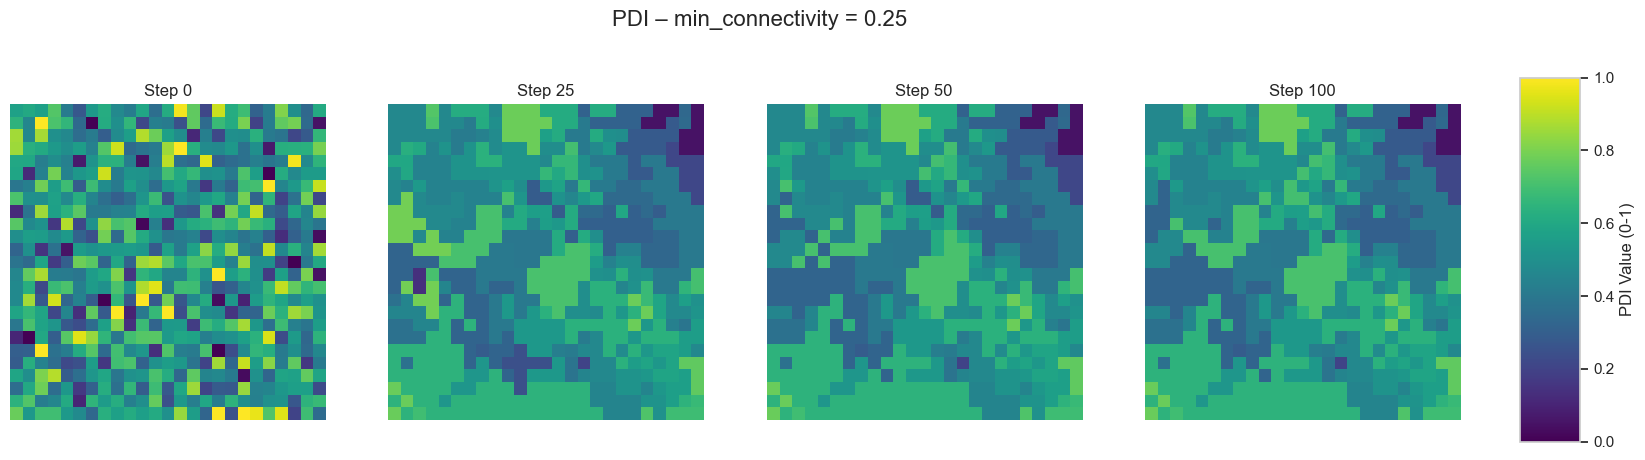

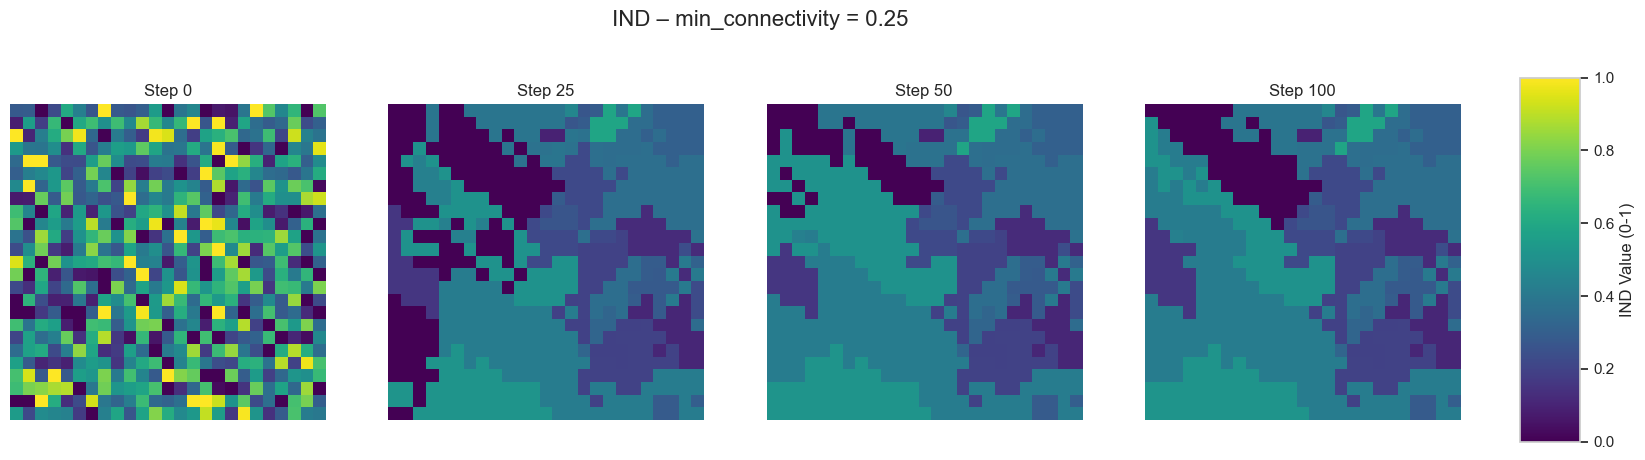

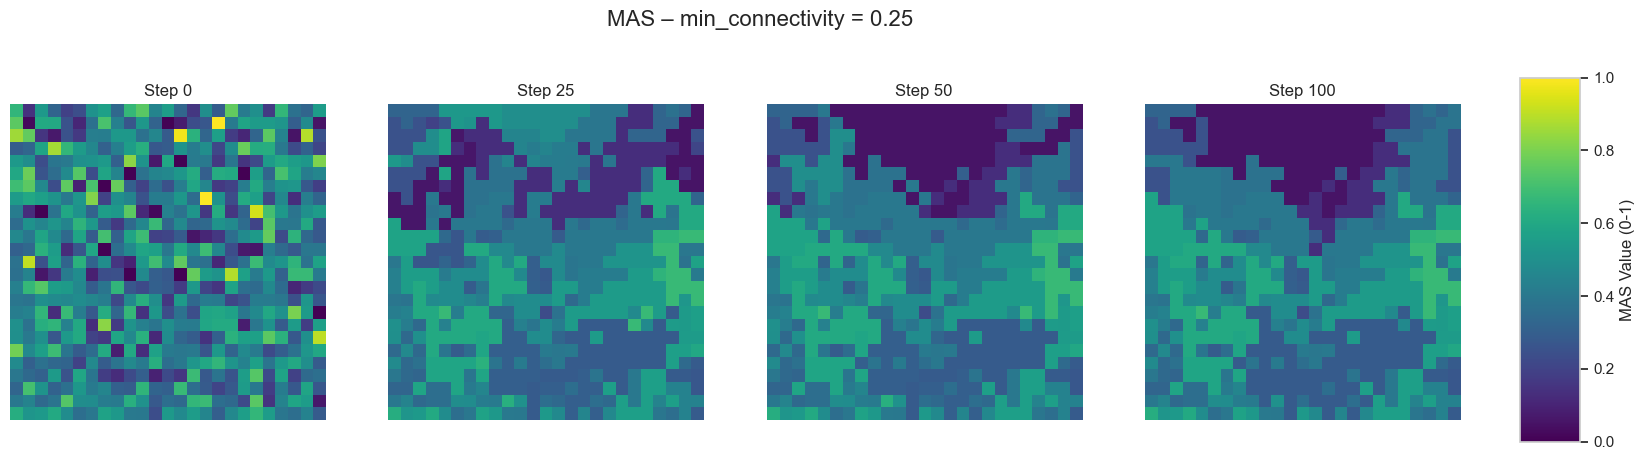

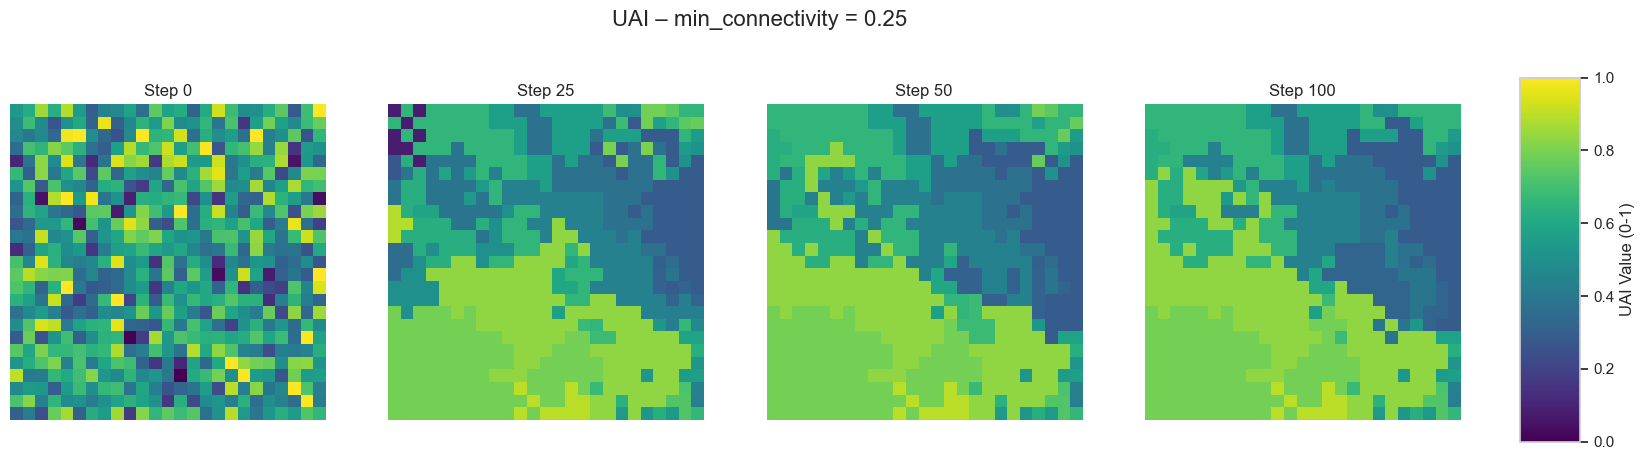

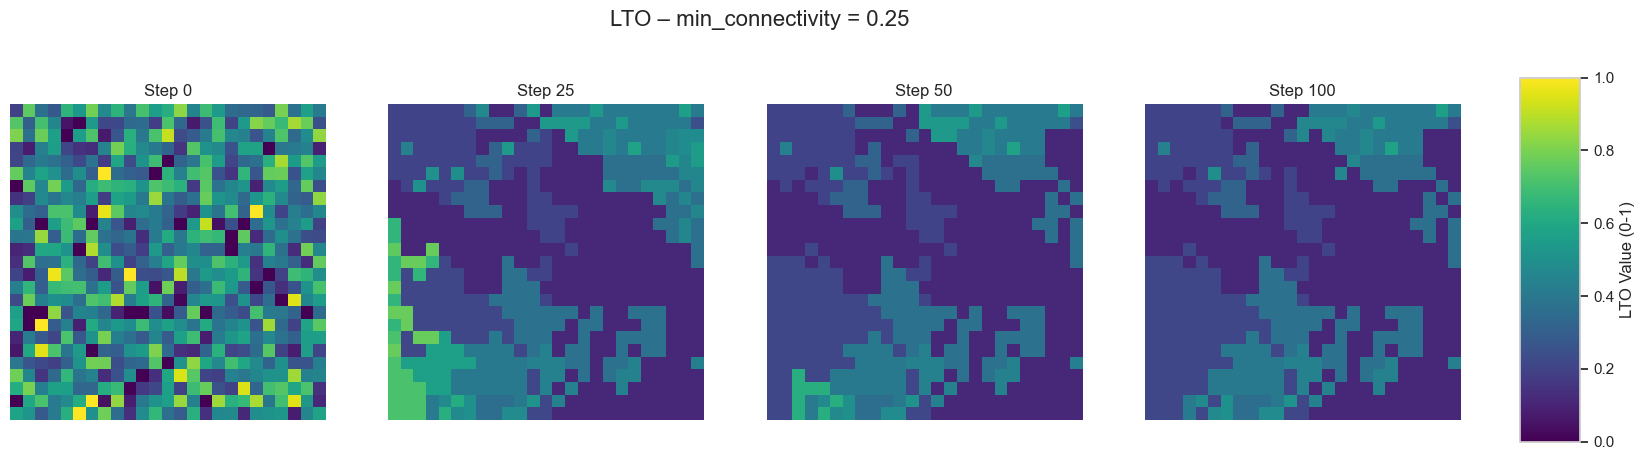

Running for min_connectivity = 0.5


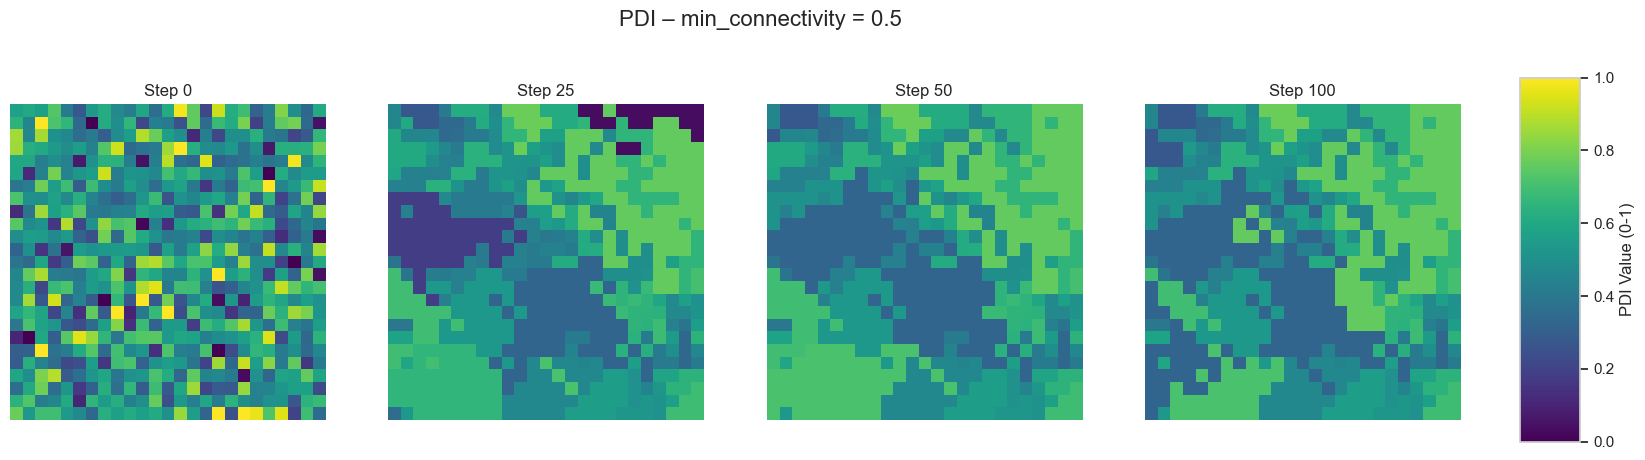

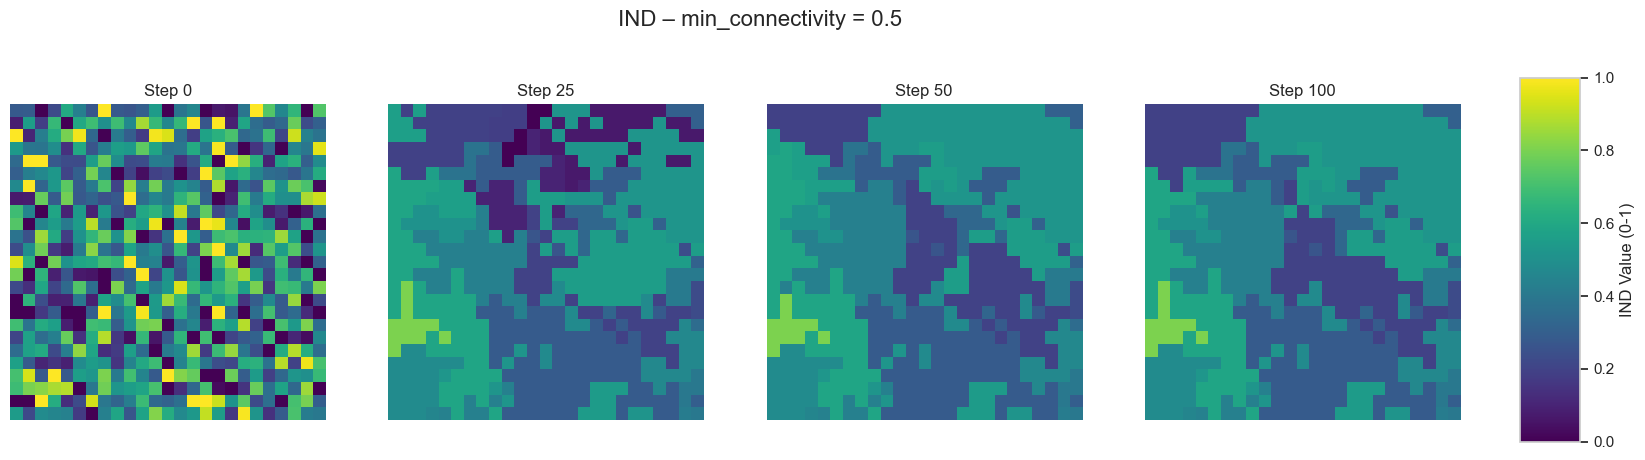

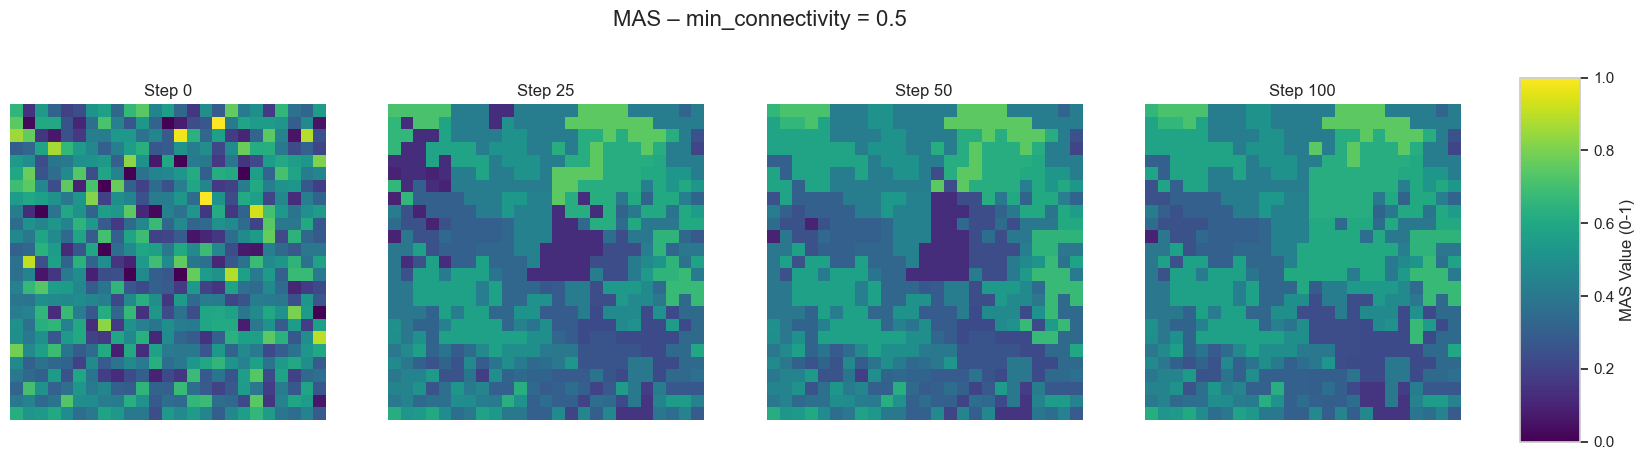

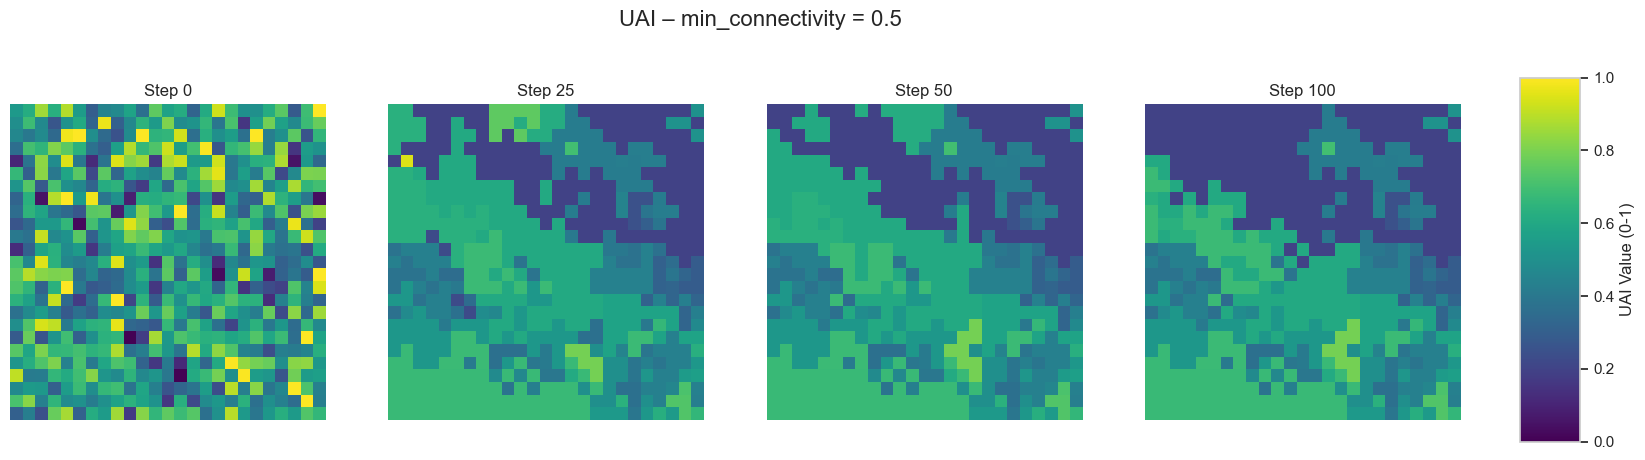

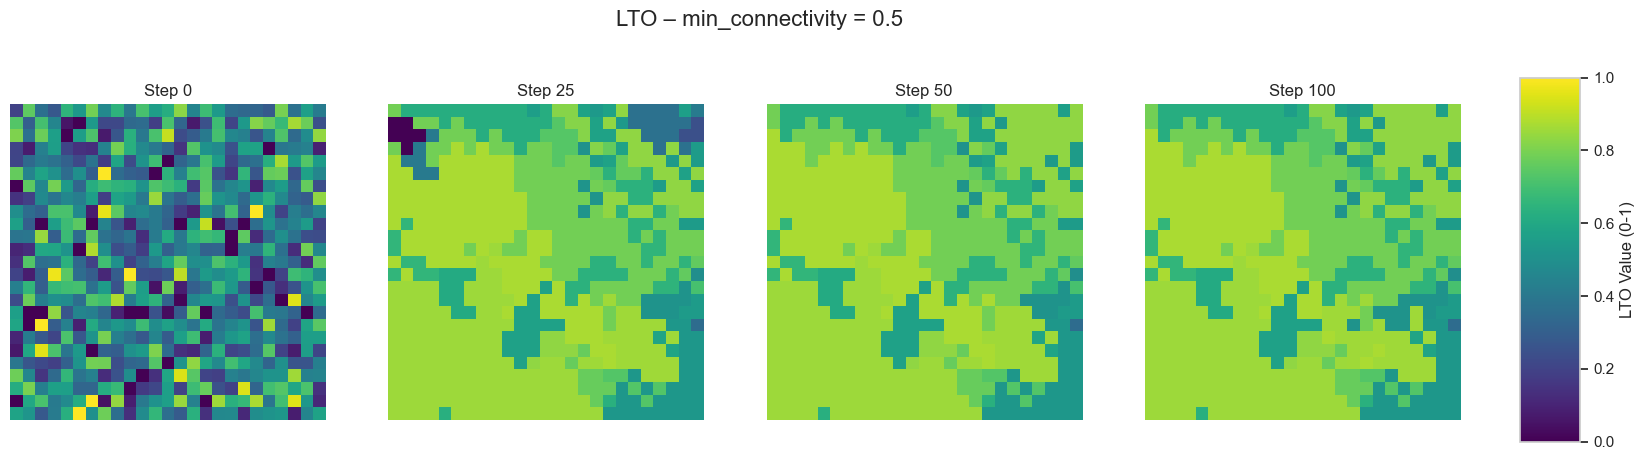

Running for min_connectivity = 0.75


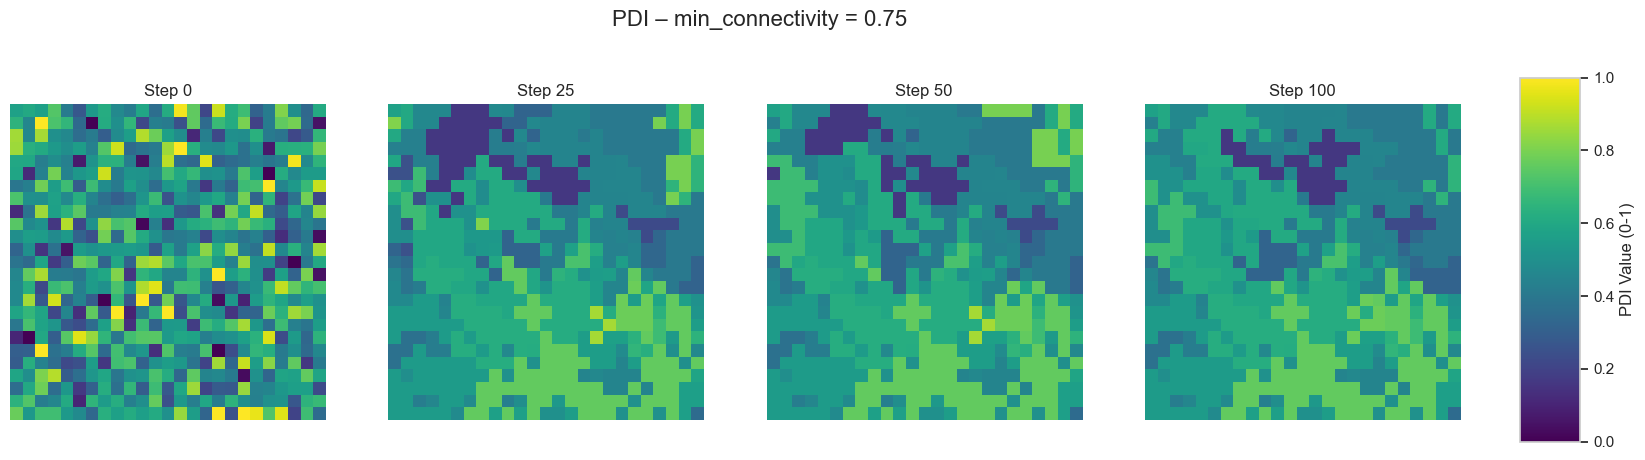

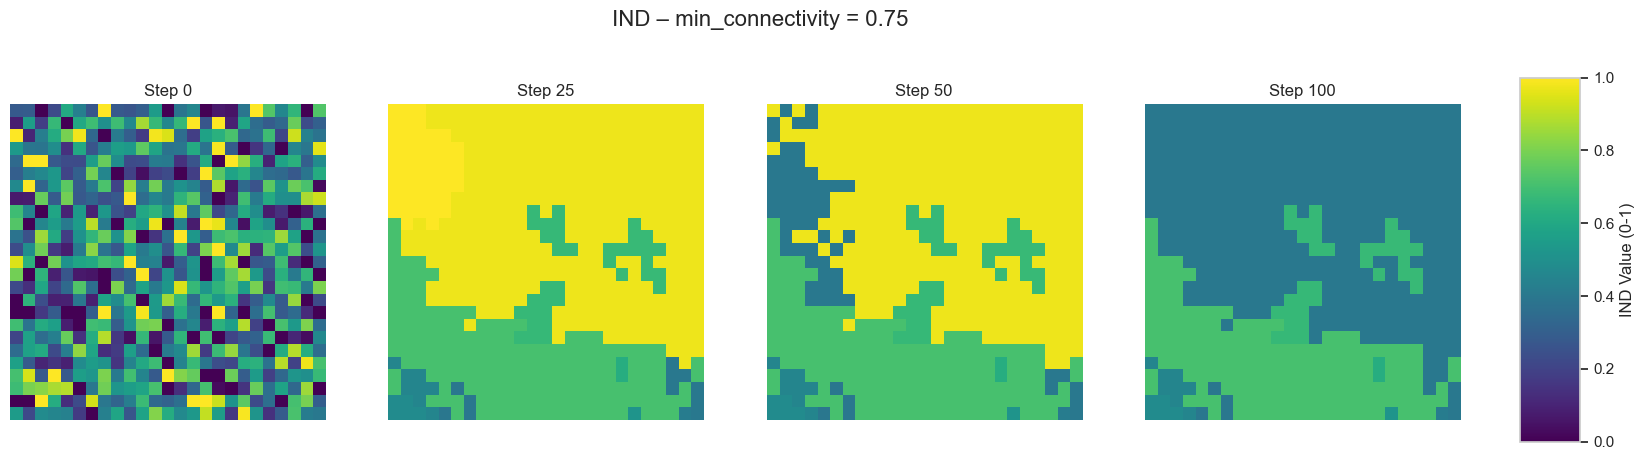

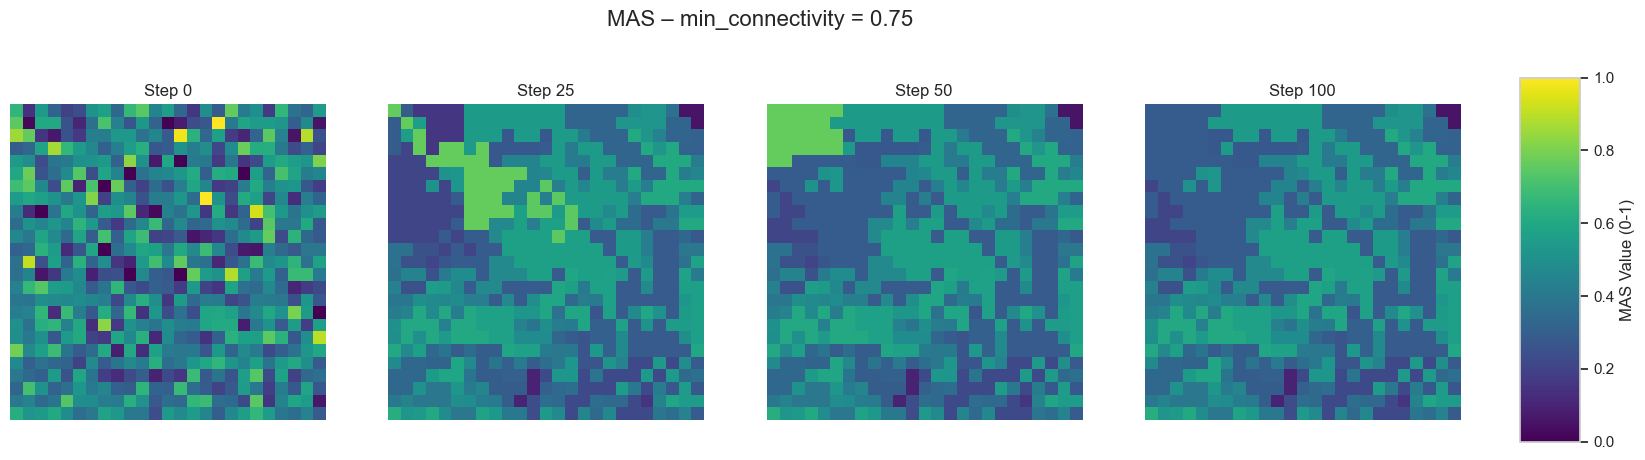

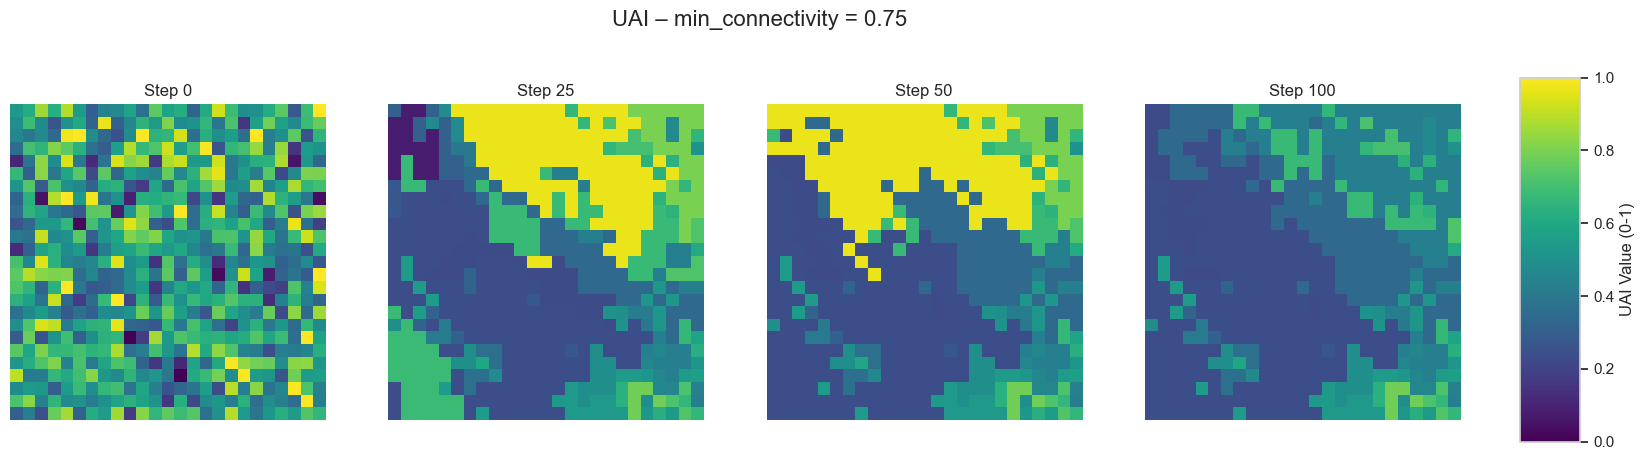

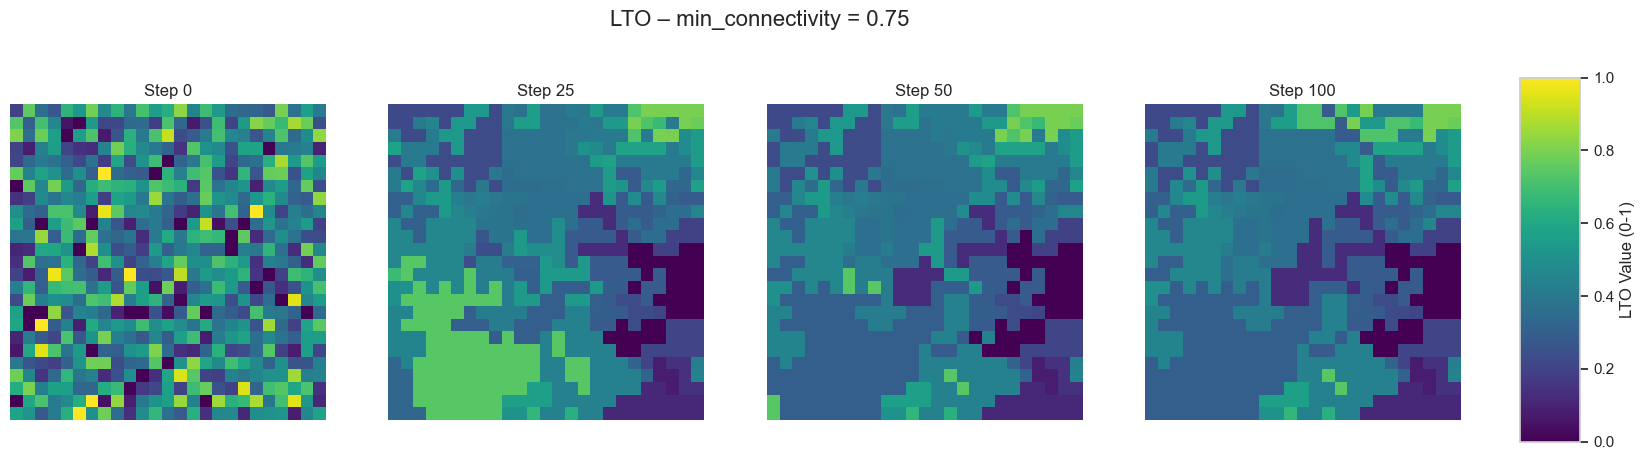

Running for min_connectivity = 1.0


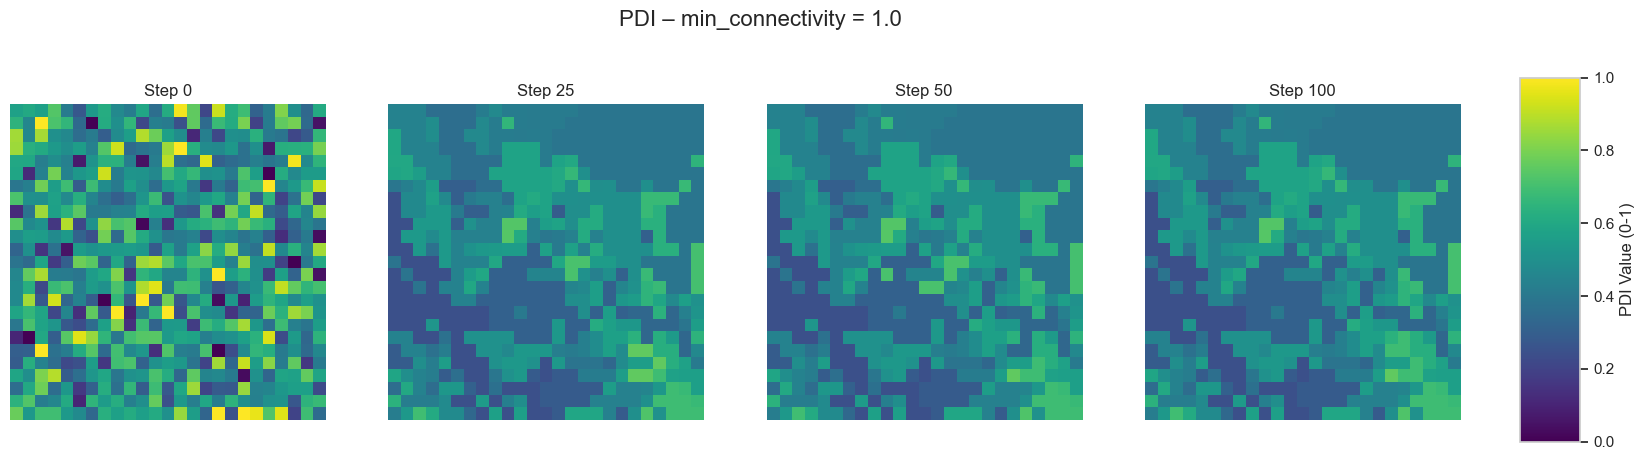

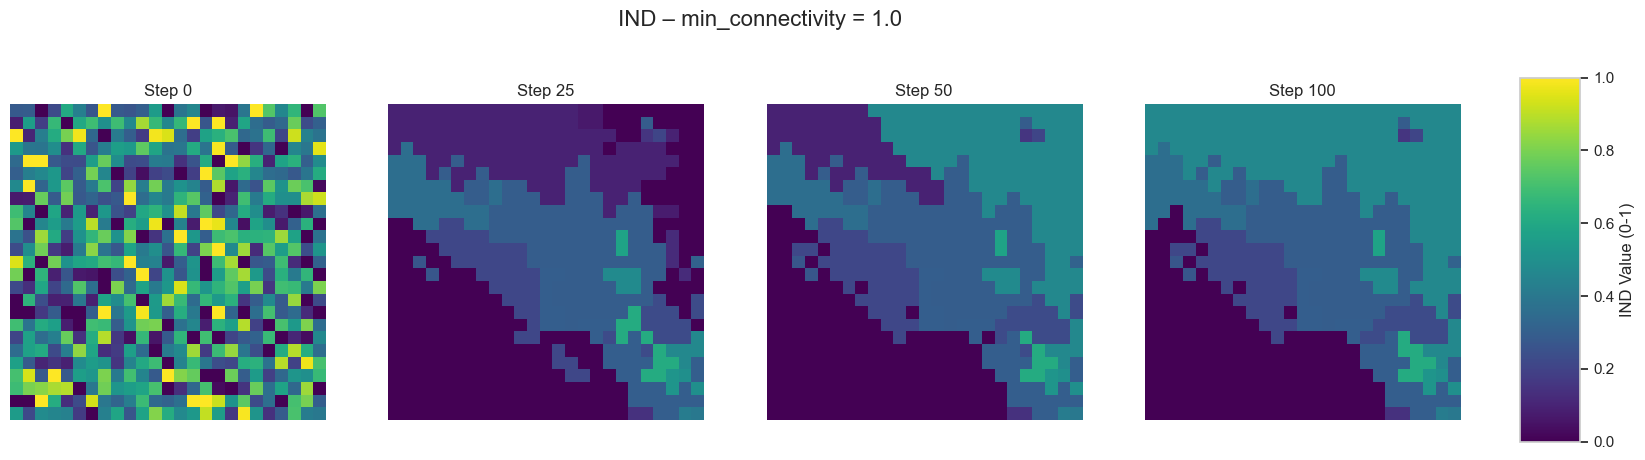

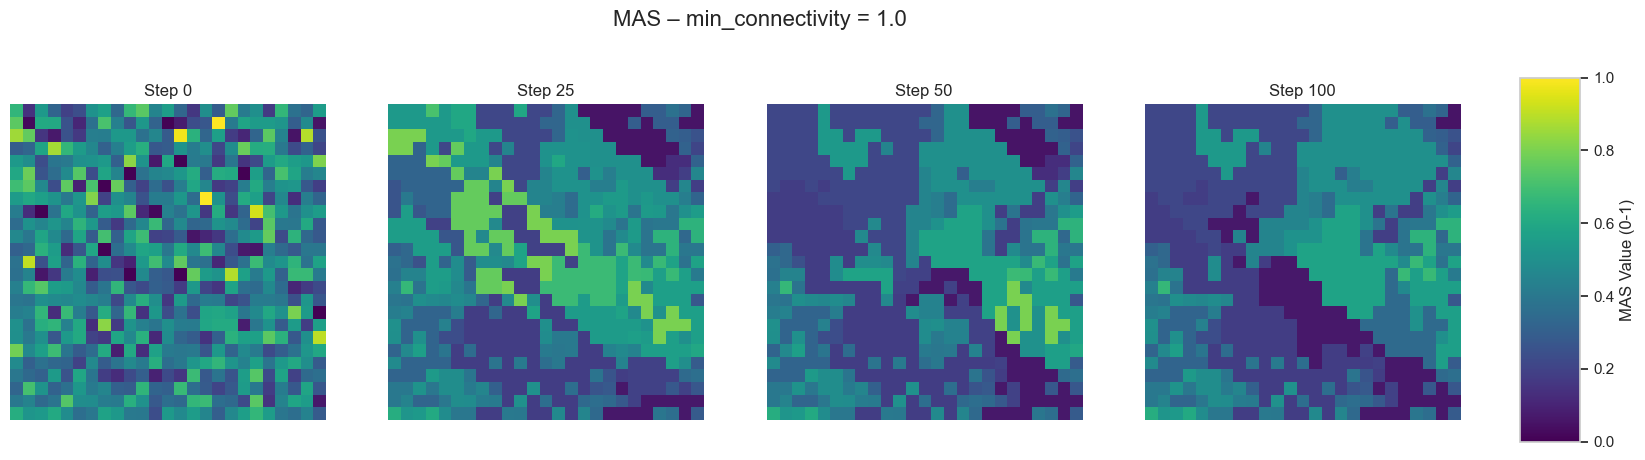

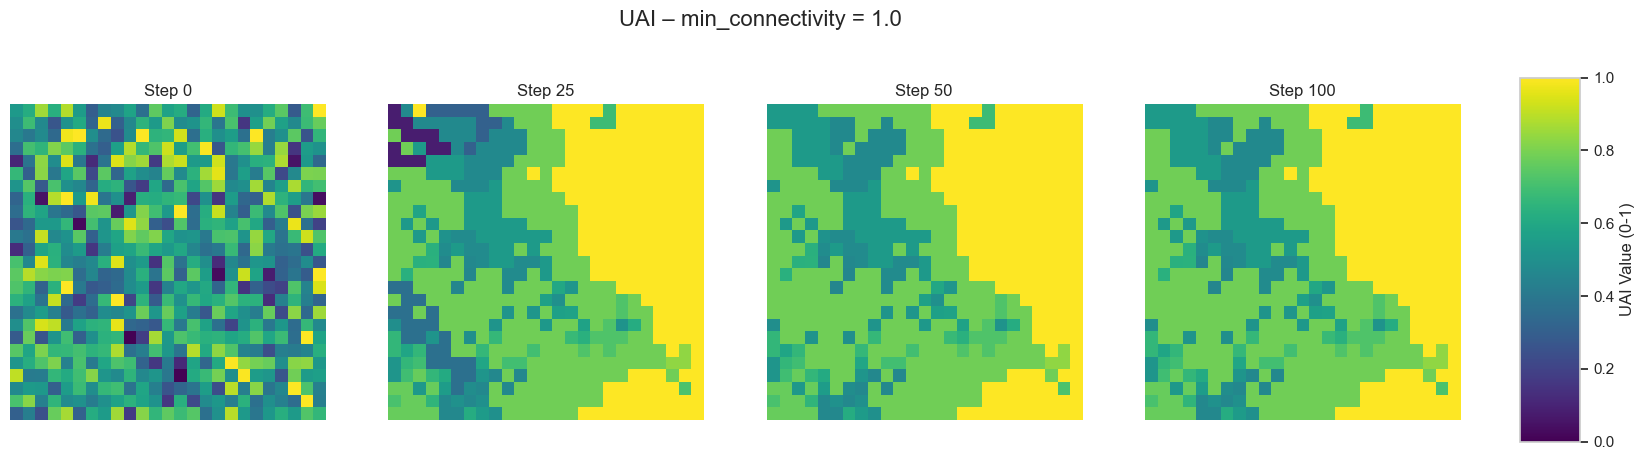

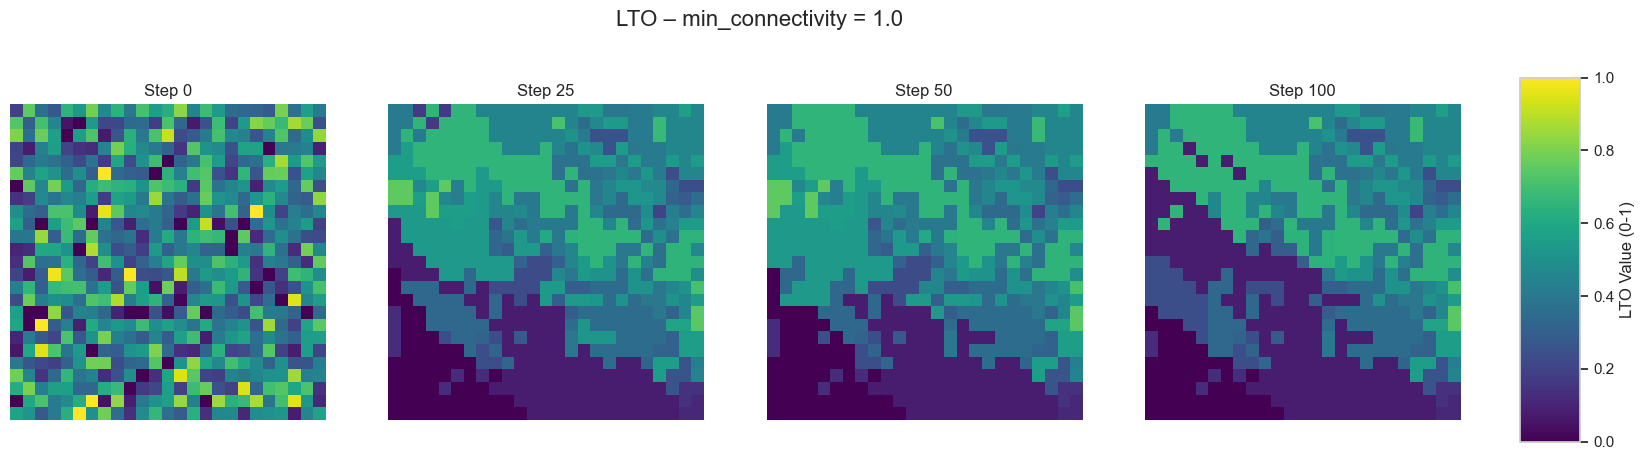

In [34]:
min_connectivity_values = [0.25, 0.5, 0.75, 1.0]
steps_to_snapshot = [0, 25, 50, 100]
max_steps = 100

def get_all_dimension_grids_for_current_step(current_model):
    grids_for_this_snapshot = []
    for dim_idx in range(current_model.num_culture_dimensions):
        dimension_grid = np.full((current_model.grid.width, current_model.grid.height), np.nan) 
        for agent in current_model.agents:
            x, y = agent.pos
            dimension_grid[x][y] = agent.culture[dim_idx]
        grids_for_this_snapshot.append(dimension_grid.T)
    return grids_for_this_snapshot

for min_conn in min_connectivity_values:
    print(f"Running for min_connectivity = {min_conn}")
    
    model = CulturalModel(
        width=25,
        height=25,
        min_connectivity=min_conn,
        use_distance=True,
        difference_threshhold=0.33,
        seed=42
    )

    dimension_names = [d_stat['name'] for d_stat in model.culture_dimension_stats]
    num_dimensions = model.num_culture_dimensions

    all_dimension_grids_over_time = []
    all_dimension_grids_over_time.append(get_all_dimension_grids_for_current_step(model))

    for step_num in range(1, max_steps + 1):
        model.step()
        if step_num in steps_to_snapshot:
            all_dimension_grids_over_time.append(get_all_dimension_grids_for_current_step(model))

    num_snapshot_occasions = len(steps_to_snapshot)

    for dim_idx in range(num_dimensions):
        current_dimension_name = dimension_names[dim_idx]

        fig, axes = plt.subplots(1, num_snapshot_occasions, figsize=(5 * num_snapshot_occasions, 5.2))
        if num_snapshot_occasions == 1:
            axes = np.array([axes])
        else:
            axes = axes.ravel()

        im = None
        for snapshot_idx, step_val in enumerate(steps_to_snapshot):
            grid_to_plot = all_dimension_grids_over_time[snapshot_idx][dim_idx]
            ax = axes[snapshot_idx]
            im = ax.imshow(grid_to_plot, cmap="viridis", vmin=0, vmax=1)
            ax.set_title(f"Step {step_val}")
            ax.axis("off")

        if im is not None:
            fig.subplots_adjust(right=0.85, top=0.88)
            cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
            fig.colorbar(im, cax=cbar_ax, label=f"{current_dimension_name} Value (0-1)")
        else:
            fig.subplots_adjust(top=0.88)

        fig.suptitle(f"{current_dimension_name} – min_connectivity = {min_conn}", fontsize=16)
        plt.show()


In [30]:
min_connectivity = [0.25, 0.5, 0.75, 1.0]
all_runs_data = []

for mc_value in min_connectivity:
    model = CulturalModel(
        width=25,
        height=25,
        min_connectivity=mc_value,
        use_distance=True,
        difference_threshhold=0.3,
        seed=42
    )
    
    for _ in range(100):
        model.step()
    run_data = model.datacollector.get_model_vars_dataframe()
    run_data["min_connectivity"] = mc_value
    run_data["Step"] = run_data.index
    all_runs_data.append(run_data)

final_combined_data = pd.concat(all_runs_data, ignore_index=True)

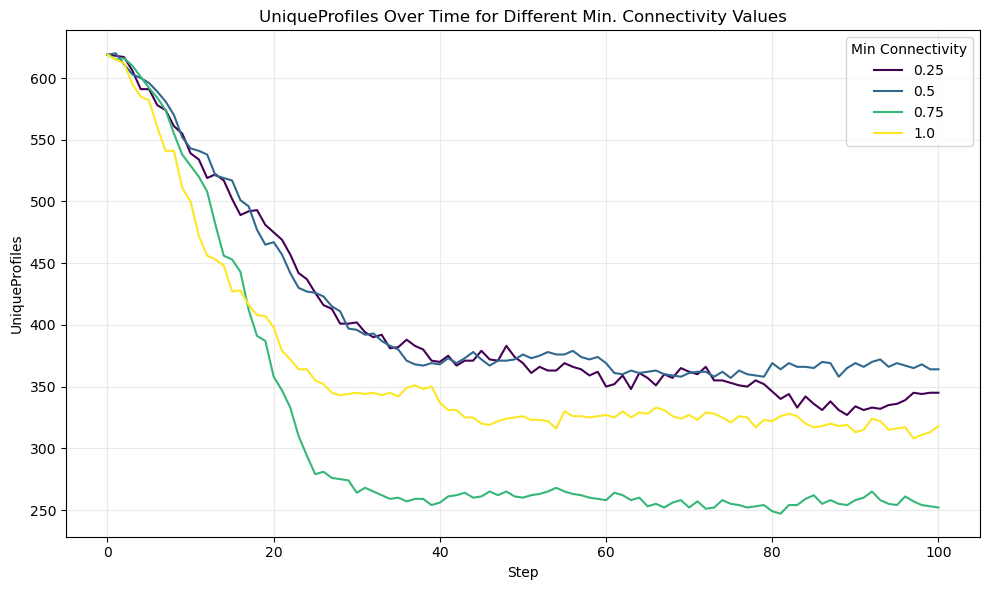

In [31]:
plt.figure(figsize=(10, 6)) 

sns.lineplot(data=final_combined_data, x="Step", y="UniqueProfiles", hue="min_connectivity", palette="viridis", legend="full")
plt.xlabel("Step")
plt.ylabel("UniqueProfiles")
plt.title("UniqueProfiles Over Time for Different Min. Connectivity Values")
plt.grid(alpha=.25)
plt.legend(title="Min Connectivity") 
plt.tight_layout()

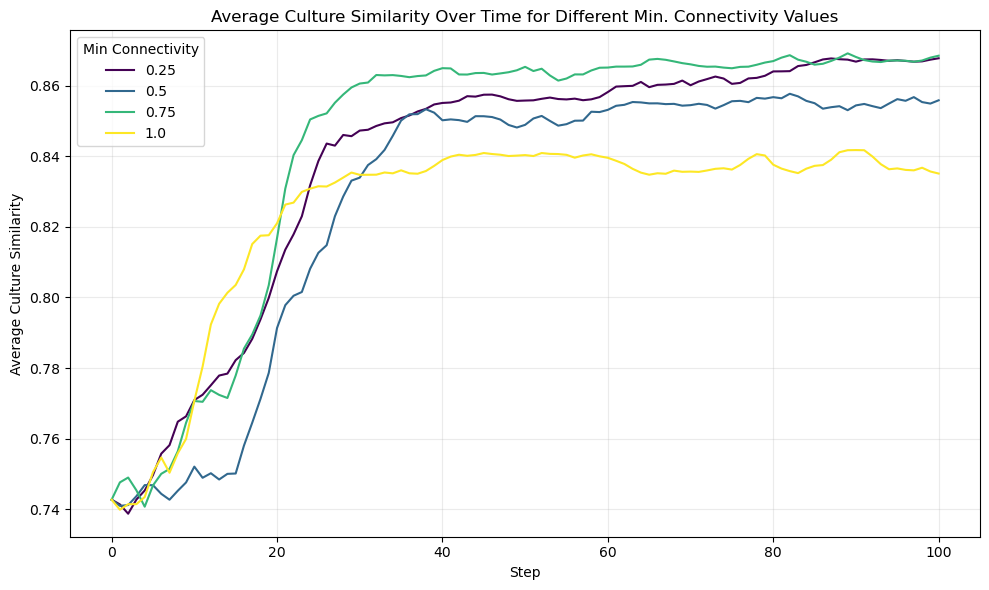

In [32]:
plt.figure(figsize=(10, 6)) 

sns.lineplot(data=final_combined_data, x="Step", y="AverageCultureSimilarity", hue="min_connectivity", palette="viridis", legend="full")
plt.xlabel("Step")
plt.ylabel("Average Culture Similarity")
plt.title("Average Culture Similarity Over Time for Different Min. Connectivity Values")
plt.grid(alpha=.25)
plt.legend(title="Min Connectivity") 
plt.tight_layout()